In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install opencv-python-headless tensorflow matplotlib scikit-image


Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import exposure
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
import os
print(os.listdir("/content/drive/MyDrive/Colab Notebooks/DIP project"))


['Barcode Detecttion dataset', 'Preprocessed']


In [ ]:
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/DIP project/Barcode Detecttion dataset'
print(os.listdir(DATASET_PATH))

['0', '1', 'images', 'labels']


Number of supported images found: 1034
Displaying images from the following paths:
/content/drive/MyDrive/Colab Notebooks/DIP project/Barcode Detecttion dataset/1/20201211_3014_rgb.png
/content/drive/MyDrive/Colab Notebooks/DIP project/Barcode Detecttion dataset/0/20201211_1981_rgb.png
/content/drive/MyDrive/Colab Notebooks/DIP project/Barcode Detecttion dataset/1/20201211_3928_rgb.png
/content/drive/MyDrive/Colab Notebooks/DIP project/Barcode Detecttion dataset/0/20201211_2466_rgb.png
/content/drive/MyDrive/Colab Notebooks/DIP project/Barcode Detecttion dataset/1/20201211_2047_rgb.png
/content/drive/MyDrive/Colab Notebooks/DIP project/Barcode Detecttion dataset/1/20201211_1938_rgb.png


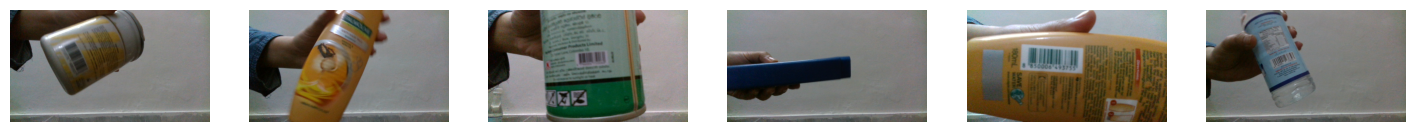

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import random

DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/DIP project/Barcode Detecttion dataset'
image_files = []
for root, dirs, files in os.walk(DATASET_PATH):
    for f in files:
        if f.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_files.append(os.path.join(root, f))

print("Number of supported images found:", len(image_files))

# Display a few random example images and their paths
if image_files:
    plt.figure(figsize=(18, 4)) # Adjusted figure size for more images
    num_images_to_display = min(6, len(image_files)) # Display 6 images

    # Randomly select images to display
    display_images = random.sample(image_files, num_images_to_display)

    print("Displaying images from the following paths:")
    for i in range(num_images_to_display):
        img_path = display_images[i]
        print(img_path)
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_images_to_display, i+1)
        plt.imshow(img_rgb)
        plt.axis('off')
    plt.show()
else:
    print("No supported images found to display. Please check your DATASET_PATH and ensure it contains .jpg, .jpeg, or .png files inside subfolders.")

Found 708 barcode images, 326 non-barcode images.


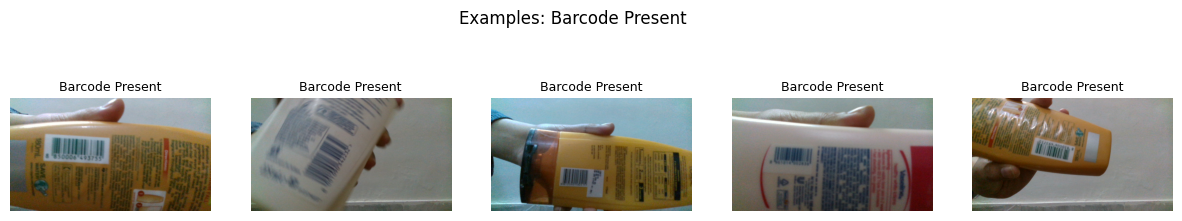

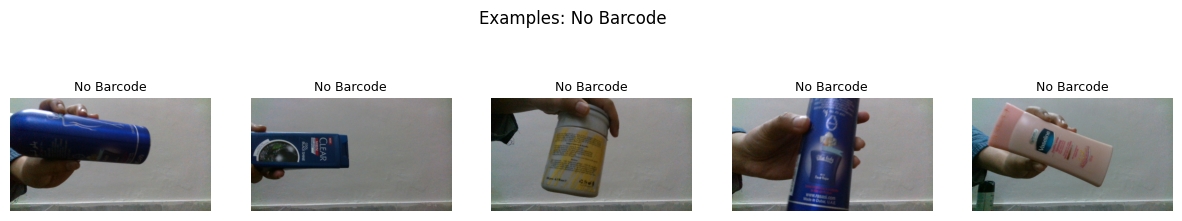

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import random
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/DIP project/Barcode Detecttion dataset'

def gather_images(dataset_path):
    barcode_images = []
    nobarcode_images = []

    for label in ['1', '0']:
        folder = os.path.join(dataset_path, label)
        for f in os.listdir(folder):
            if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(folder, f)
                if label == '1':
                    barcode_images.append(img_path)
                else:
                    nobarcode_images.append(img_path)

    return barcode_images, nobarcode_images

barcode_imgs, nobarcode_imgs = gather_images(DATASET_PATH)
print(f'Found {len(barcode_imgs)} barcode images, {len(nobarcode_imgs)} non-barcode images.')

# Visualize random samples
def show_examples(image_list, title, num_images=5):
    plt.figure(figsize=(15, 3))
    sample_imgs = random.sample(image_list, min(num_images, len(image_list)))
    for i, img_path in enumerate(sample_imgs):
        img = cv2.imread(img_path)
        if img is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1, num_images, i+1)
            plt.imshow(img_rgb)
            plt.title(title, fontsize=9)
            plt.axis('off')
        else:
            print("Could not read:", img_path)
    plt.suptitle(f"Examples: {title}")
    plt.show()

show_examples(barcode_imgs, "Barcode Present")
show_examples(nobarcode_imgs, "No Barcode")


Preprocessing (grayscale, blur, histogram equalization)

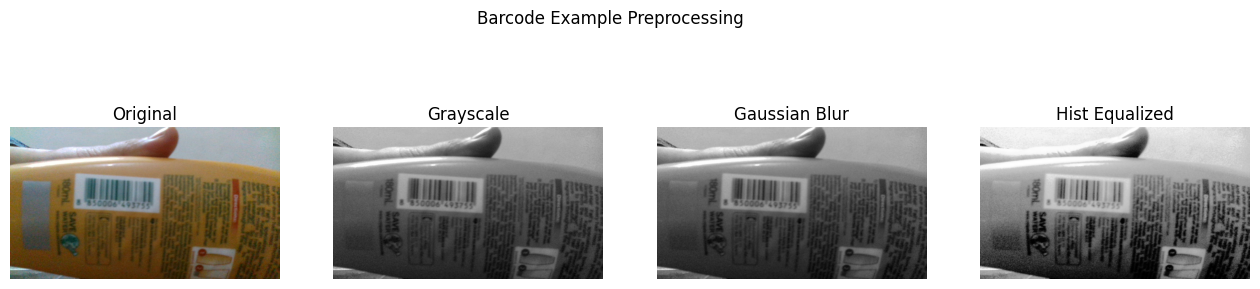

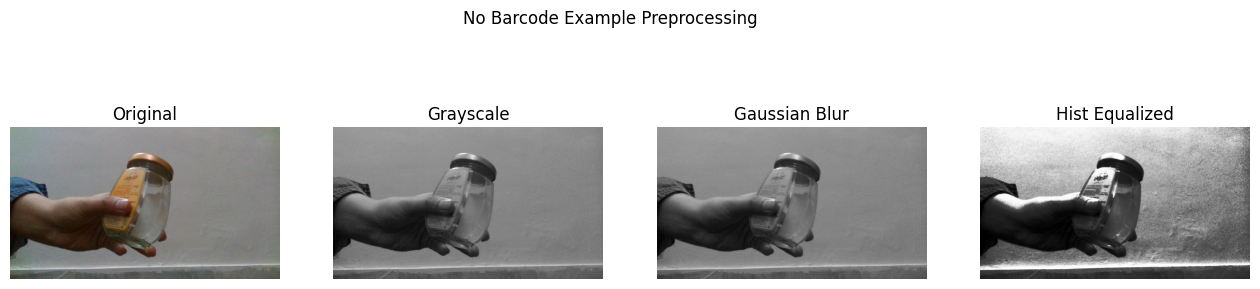

In [ ]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    eq = cv2.equalizeHist(blur) # Contrast enhancement
    return img, gray, blur, eq

# Pick examples
barcode_example = random.choice(barcode_imgs)
nobarcode_example = random.choice(nobarcode_imgs)

def show_preprocessing(img_path, title):
    orig, gray, blur, eq = preprocess_image(img_path)
    images = [orig, gray, blur, eq]
    labels = ['Original', 'Grayscale', 'Gaussian Blur', 'Hist Equalized']
    plt.figure(figsize=(16, 4))
    for i, (img, label) in enumerate(zip(images, labels)):
        plt.subplot(1, 4, i+1)
        if len(img.shape) == 2:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(label)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

show_preprocessing(barcode_example, "Barcode Example Preprocessing")
show_preprocessing(nobarcode_example, "No Barcode Example Preprocessing")


 Edge Detection

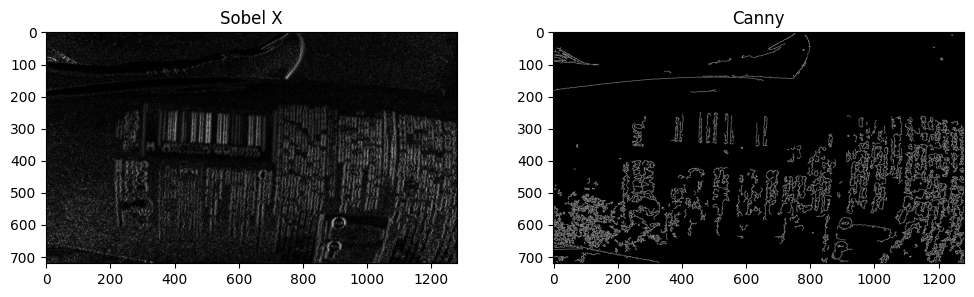

In [ ]:
def detect_edges(eq_img):
    # Use Sobel for vertical edge detection (barcodes have strong vertical lines)
    sobelx = cv2.Sobel(eq_img, cv2.CV_64F, 1, 0, ksize=3)
    sobelx = cv2.convertScaleAbs(sobelx)
    # Or, use Canny
    canny = cv2.Canny(eq_img, 50, 150)
    return sobelx, canny

# Example for one image:
orig, gray, blur, eq = preprocess_image(barcode_example)
sobelx, canny = detect_edges(eq)
plt.figure(figsize=(12,3))
plt.subplot(1,2,1), plt.imshow(sobelx, cmap='gray'), plt.title("Sobel X")
plt.subplot(1,2,2), plt.imshow(canny, cmap='gray'), plt.title("Canny")
plt.show()


Morphological Operations

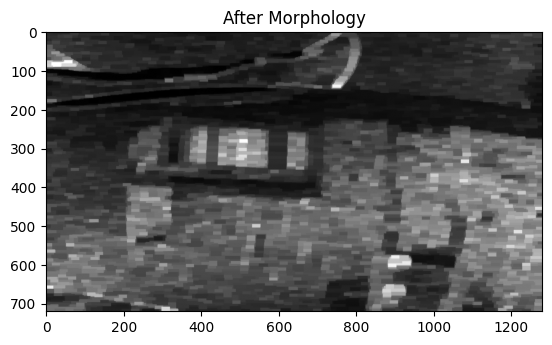

In [ ]:
def morph_ops(edge_img):
    # Structuring element (tuned for barcode size)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
    # Dilation followed by closing
    dilated = cv2.dilate(edge_img, kernel, iterations=1)
    closed = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel)
    # Remove small objects (opening)
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (9,3)))
    return opened

mor = morph_ops(sobelx)
plt.imshow(mor, cmap='gray')
plt.title('After Morphology')
plt.show()


roi


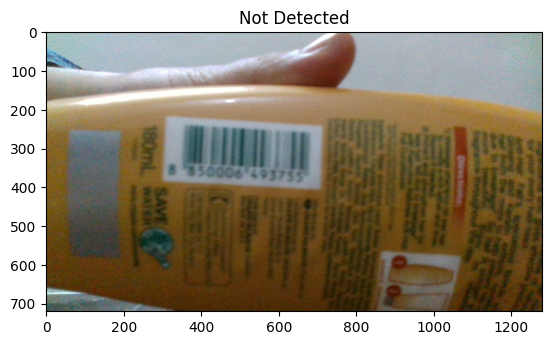

In [ ]:
def find_barcode_roi(morphed_img, orig_img):
    contours, _ = cv2.findContours(morphed_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    barcode_contour = None
    max_area = 0
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        aspect_ratio = w / float(h)
        area = cv2.contourArea(cnt)
        # Empirically, barcodes are wide rectangles, area threshold may be dataset-dependent
        if area > 5000 and aspect_ratio > 1.8:
            if area > max_area:
                max_area = area
                barcode_contour = (x, y, w, h)
    result_img = orig_img.copy()
    found = False
    if barcode_contour is not None:
        x, y, w, h = barcode_contour
        cv2.rectangle(result_img, (x, y), (x+w, y+h), (0,255,0), 3)
        found = True
    return result_img, found

# Try on one image
marked_image, detected = find_barcode_roi(mor, orig)
plt.imshow(cv2.cvtColor(marked_image, cv2.COLOR_BGR2RGB))
plt.title("Barcode Detected" if detected else "Not Detected")
plt.show()


In [ ]:
def find_barcode_roi(morphed_img, orig_img):
    contours, _ = cv2.findContours(morphed_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    possible_barcodes = []
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        aspect_ratio = w / float(h)
        area = cv2.contourArea(cnt)
        # RELAXED FILTERS FOR REAL WORLD!
        if area > 800 and 1.0 < aspect_ratio < 7.0:
            possible_barcodes.append((x, y, w, h, area))
    # Pick LARGEST region as best guess
    if possible_barcodes:
        possible_barcodes = sorted(possible_barcodes, key=lambda e: e[4], reverse=True)
        x, y, w, h, _ = possible_barcodes[0]
        cv2.rectangle(orig_img, (x, y), (x+w, y+h), (0,255,0), 3)
        return orig_img, True
    else:
        return orig_img, False


cnn


In [ ]:
!pip install tensorflow --quiet


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil
from sklearn.model_selection import train_test_split

img_size = 128  # Or 224 if you want bigger images
batch_size = 16

# Define paths for new dataset structure
base_dir = 'dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

# Create the directory structure if it doesn't exist
for d in [os.path.join(train_dir, '0'), os.path.join(train_dir, '1'),
          os.path.join(val_dir, '0'), os.path.join(val_dir, '1')]:
    os.makedirs(d, exist_ok=True)

# Split images into training and validation sets
# Assuming barcode_imgs and nobarcode_imgs are defined from previous cells
# Use a fixed random state for reproducibility
train_barcode, val_barcode = train_test_split(barcode_imgs, test_size=0.2, random_state=42)
train_nobarcode, val_nobarcode = train_test_split(nobarcode_imgs, test_size=0.2, random_state=42)

# Copy files to the new directory structure
def copy_images(image_list, destination_folder):
    for img_path in image_list:
        shutil.copy(img_path, destination_folder)

print("Copying training barcode images...")
copy_images(train_barcode, os.path.join(train_dir, '1'))
print("Copying training non-barcode images...")
copy_images(train_nobarcode, os.path.join(train_dir, '0'))

print("Copying validation barcode images...")
copy_images(val_barcode, os.path.join(val_dir, '1'))
print("Copying validation non-barcode images...")
copy_images(val_nobarcode, os.path.join(val_dir, '0'))

print("Dataset structure created and populated.")

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

print(f"Found {train_gen.n} training images belonging to {train_gen.num_classes} classes.")
print(f"Found {val_gen.n} validation images belonging to {val_gen.num_classes} classes.")


Copying training barcode images...
Copying training non-barcode images...
Copying validation barcode images...
Copying validation non-barcode images...
Dataset structure created and populated.
Found 661 images belonging to 2 classes.
Found 41 images belonging to 2 classes.
Found 661 training images belonging to 2 classes.
Found 41 validation images belonging to 2 classes.


simple cnn model

In [ ]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,699,009 (6.48 MB)

 Trainable params: 1,699,009 (6.48 MB)

 Non-trainable params: 0 (0.00 B)

train cnn model

In [ ]:
history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_gen.samples // batch_size
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 37s 838ms/step - accuracy: 0.6540 - loss: 0.6129 - val_accuracy: 0.6875 - val_loss: 0.6264
Epoch 2/20
 1/41 ━━━━━━━━━━━━━━━━━━━━ 34s 869ms/step - accuracy: 0.9375 - loss: 0.2629

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9375 - loss: 0.2629 - val_accuracy: 0.6562 - val_loss: 0.6858
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 977ms/step - accuracy: 0.8846 - loss: 0.3715 - val_accuracy: 0.6875 - val_loss: 1.0802
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.8750 - loss: 0.2690 - val_accuracy: 0.6562 - val_loss: 1.1837
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 71s 784ms/step - accuracy: 0.9259 - loss: 0.2145 - val_accuracy: 0.5625 - val_loss: 1.1670
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8750 - loss: 0.2341 - val_accuracy: 0.7188 - val_loss: 0.8163
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 39s 776ms/step - accuracy: 0.9624 - loss: 0.1174 - val_accuracy: 0.7500 - val_loss: 1.0910
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 1.0000 - loss: 0.0417 - val_accuracy: 0.6875 - val_loss: 1.1881
Epoch 9/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 997ms/step - accuracy: 0.9794 - loss: 0.0515 - val_accuracy: 0.7812 - val_

plot

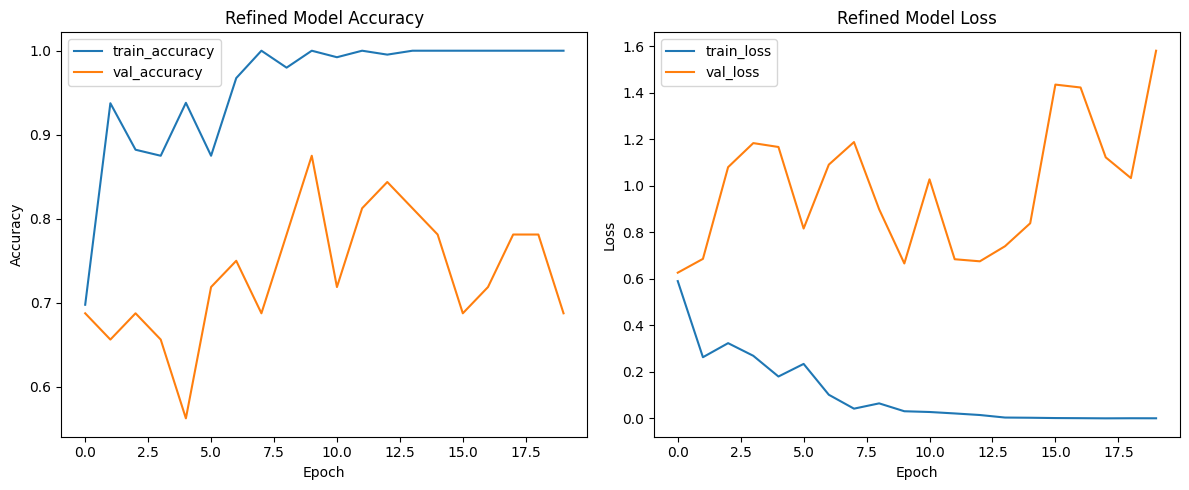

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values for the refined model
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Refined Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values for the refined model
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Refined Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Barcode Detected


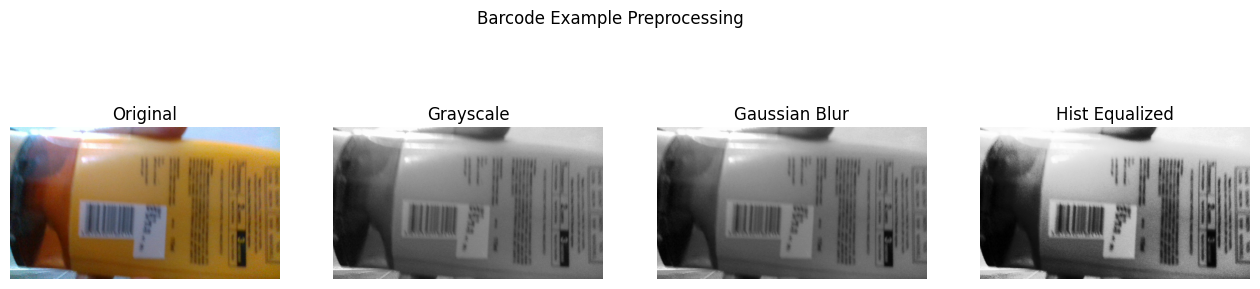

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = '/content/dataset/validation/1/20201211_1044_rgb.png'
img = image.load_img(img_path, target_size=(img_size, img_size))
img_arr = image.img_to_array(img)/255.0
img_arr = np.expand_dims(img_arr, axis=0)

pred = model.predict(img_arr)[0][0]
if pred < 0.5:
    print('No Barcode Detected')
else:
    print('Barcode Detected')
    show_preprocessing(img_path, "Barcode Example Preprocessing")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
No Barcode Detected


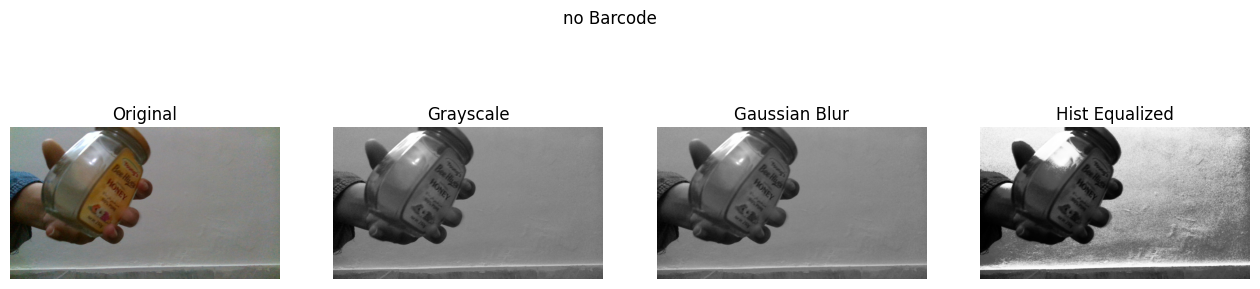

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = '/content/dataset/validation/0/20201211_106_rgb.png'
img = image.load_img(img_path, target_size=(img_size, img_size))
img_arr = image.img_to_array(img)/255.0
img_arr = np.expand_dims(img_arr, axis=0)

pred = model.predict(img_arr)[0][0]
if pred < 0.5:
    print('No Barcode Detected')
    show_preprocessing(img_path, "no Barcode")
else:
    print('Barcode Detected')
    show_preprocessing(img_path, "Barcode Example Preprocessing")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Barcode Detected


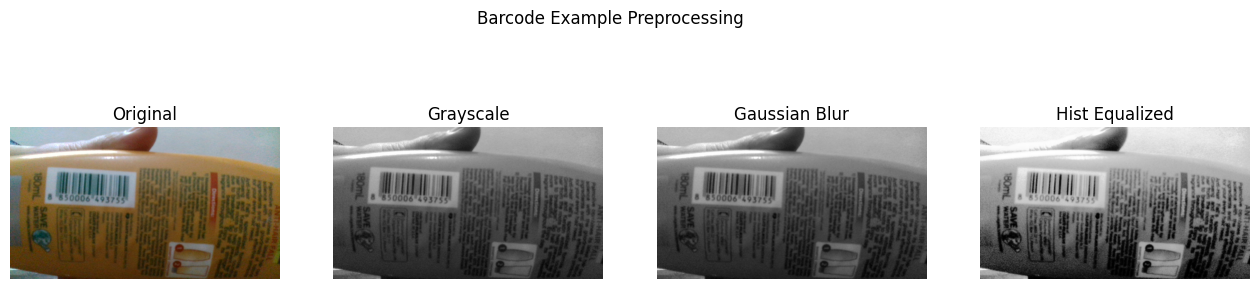

In [ ]:

import numpy as np
from tensorflow.keras.preprocessing import image

img_path = '/content/dataset/validation/1/20201211_2023_rgb.png'
img = image.load_img(img_path, target_size=(img_size, img_size))
img_arr = image.img_to_array(img)/255.0
img_arr = np.expand_dims(img_arr, axis=0)

pred = model.predict(img_arr)[0][0]
if pred < 0.5:
    print('No Barcode Detected')
    show_preprocessing(img_path, "no Barcode")
else:
    print('Barcode Detected')
    show_preprocessing(img_path, "Barcode Example Preprocessing")


## Enhance Data Augmentation and Callbacks



In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2 # Still needed for validation split within the generator
)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

print(f"Found {train_gen.n} training images belonging to {train_gen.num_classes} classes.")
print(f"Found {val_gen.n} validation images belonging to {val_gen.num_classes} classes.")

Found 661 images belonging to 2 classes.
Found 41 images belonging to 2 classes.
Found 661 training images belonging to 2 classes.
Found 41 validation images belonging to 2 classes.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Instantiate EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Instantiate ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    'best_model.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

print("EarlyStopping and ModelCheckpoint callbacks initialized.")

EarlyStopping and ModelCheckpoint callbacks initialized.


In [ ]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25), # Added dropout layer
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25), # Added dropout layer
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25), # Added dropout layer
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5), # Added dropout layer
    layers.Dense(1, activation='sigmoid')  # binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,699,009 (6.48 MB)

 Trainable params: 1,699,009 (6.48 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_gen.samples // batch_size,
    callbacks=[early_stopping, model_checkpoint]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 914ms/step - accuracy: 0.6360 - loss: 0.7210
Epoch 1: val_loss improved from inf to 0.66871, saving model to best_model.weights.h5
41/41 ━━━━━━━━━━━━━━━━━━━━ 44s 990ms/step - accuracy: 0.6368 - loss: 0.7199 - val_accuracy: 0.6875 - val_loss: 0.6687
Epoch 2/20
 1/41 ━━━━━━━━━━━━━━━━━━━━ 30s 775ms/step - accuracy: 0.6875 - loss: 0.6452

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 0.66871 to 0.65817, saving model to best_model.weights.h5
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.6875 - loss: 0.6452 - val_accuracy: 0.7188 - val_loss: 0.6582
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 890ms/step - accuracy: 0.6661 - loss: 0.6368
Epoch 3: val_loss improved from 0.65817 to 0.62372, saving model to best_model.weights.h5
41/41 ━━━━━━━━━━━━━━━━━━━━ 38s 928ms/step - accuracy: 0.6666 - loss: 0.6365 - val_accuracy: 0.6875 - val_loss: 0.6237
Epoch 4/20
 1/41 ━━━━━━━━━━━━━━━━━━━━ 19s 491ms/step - accuracy: 0.6250 - loss: 0.7033
Epoch 4: val_loss did not improve from 0.62372
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.6250 - loss: 0.7033 - val_accuracy: 0.6562 - val_loss: 0.6491
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 899ms/step - accuracy: 0.7042 - loss: 0.6037
Epoch 5: val_loss did not improve from 0.62372
41/41 ━━━━━━━━━━━━━━━━━━━━ 39s 929ms/step - accuracy: 0.7038 - loss: 0.6043 - val_accuracy: 0.6875 - val_loss: 0.662

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)


train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary'
)

print(f"Found {train_gen.n} training images belonging to {train_gen.num_classes} classes.")
print(f"Found {val_gen.n} validation images belonging to {val_gen.num_classes} classes.")

Found 826 images belonging to 2 classes.
Found 208 images belonging to 2 classes.
Found 826 training images belonging to 2 classes.
Found 208 validation images belonging to 2 classes.


In [ ]:
history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    epochs=50, # Increased epochs as EarlyStopping will handle stopping
    validation_data=val_gen,
    validation_steps=val_gen.samples // batch_size,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 901ms/step - accuracy: 0.7187 - loss: 0.5480
Epoch 1: val_loss improved from 0.54555 to 0.45976, saving model to best_model.weights.h5
51/51 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.7190 - loss: 0.5480 - val_accuracy: 0.7788 - val_loss: 0.4598
Epoch 2/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 29s 593ms/step - accuracy: 0.7500 - loss: 0.4609
Epoch 2: val_loss did not improve from 0.45976
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.7500 - loss: 0.4609 - val_accuracy: 0.7644 - val_loss: 0.4600
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 863ms/step - accuracy: 0.7283 - loss: 0.5314
Epoch 3: val_loss improved from 0.45976 to 0.40525, saving model to best_model.weights.h5
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.7285 - loss: 0.5312 - val_accuracy: 0.8173 - val_loss: 0.4053
Epoch 4/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 21s 430ms/step - accuracy: 0.6250 - loss: 0.5527
Epoch 4: val_loss did not improve from 0.40525
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 120

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 12: val_loss improved from 0.39053 to 0.38773, saving model to best_model.weights.h5
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 207ms/step - accuracy: 0.8125 - loss: 0.4098 - val_accuracy: 0.8269 - val_loss: 0.3877
Epoch 13/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 868ms/step - accuracy: 0.7641 - loss: 0.4763
Epoch 13: val_loss improved from 0.38773 to 0.37964, saving model to best_model.weights.h5
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 991ms/step - accuracy: 0.7640 - loss: 0.4766 - val_accuracy: 0.8413 - val_loss: 0.3796
Epoch 14/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 26s 523ms/step - accuracy: 0.6250 - loss: 0.6872

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 14: val_loss did not improve from 0.37964
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.6250 - loss: 0.6872 - val_accuracy: 0.8462 - val_loss: 0.3816
Epoch 15/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 863ms/step - accuracy: 0.7663 - loss: 0.4642
Epoch 15: val_loss improved from 0.37964 to 0.35309, saving model to best_model.weights.h5
51/51 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7663 - loss: 0.4643 - val_accuracy: 0.8654 - val_loss: 0.3531
Epoch 16/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.8125 - loss: 0.3949
Epoch 16: val_loss did not improve from 0.35309
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 0.8125 - loss: 0.3949 - val_accuracy: 0.8606 - val_loss: 0.3542
Epoch 17/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 851ms/step - accuracy: 0.7899 - loss: 0.4715
Epoch 17: val_loss did not improve from 0.35309
51/51 ━━━━━━━━━━━━━━━━━━━━ 70s 980ms/step - accuracy: 0.7897 - loss: 0.4718 - val_accuracy: 0.8462 - val_loss: 0.3822
Epoch 18/50
 1/51 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 22: val_loss did not improve from 0.32185
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 0.7500 - loss: 0.5242 - val_accuracy: 0.8413 - val_loss: 0.3350
Epoch 23/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 875ms/step - accuracy: 0.7694 - loss: 0.4647
Epoch 23: val_loss did not improve from 0.32185
51/51 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.7699 - loss: 0.4643 - val_accuracy: 0.8558 - val_loss: 0.3249
Epoch 24/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 21s 437ms/step - accuracy: 0.6875 - loss: 0.5881
Epoch 24: val_loss did not improve from 0.32185
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 205ms/step - accuracy: 0.6875 - loss: 0.5881 - val_accuracy: 0.8558 - val_loss: 0.3268
Epoch 25/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 888ms/step - accuracy: 0.8000 - loss: 0.4094
Epoch 25: val_loss did not improve from 0.32185
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.7997 - loss: 0.4100 - val_accuracy: 0.8269 - val_loss: 0.3814
Epoch 26/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 21s 439ms/step - accuracy: 0.7500 - loss:

## Refine CNN Architecture with Dropout




In [ ]:
history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    epochs=50, # Increased epochs as EarlyStopping will handle stopping
    validation_data=val_gen,
    validation_steps=val_gen.samples // batch_size,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - accuracy: 0.8710 - loss: 0.3307
Epoch 1: val_loss did not improve from 0.17815
51/51 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8710 - loss: 0.3303 - val_accuracy: 0.9038 - val_loss: 0.2156
Epoch 2/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 21s 437ms/step - accuracy: 0.8750 - loss: 0.2660
Epoch 2: val_loss did not improve from 0.17815
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.8750 - loss: 0.2660 - val_accuracy: 0.8846 - val_loss: 0.2256
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 867ms/step - accuracy: 0.8635 - loss: 0.2990
Epoch 3: val_loss improved from 0.17815 to 0.16626, saving model to best_model.weights.h5
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8637 - loss: 0.2989 - val_accuracy: 0.9375 - val_loss: 0.1663
Epoch 4/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 22s 448ms/step - accuracy: 0.9375 - loss: 0.2176
Epoch 4: val_loss improved from 0.16626 to 0.16265, saving model to best_model.weights.h5
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 124

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 12: val_loss did not improve from 0.16265
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 0.1076 - val_accuracy: 0.8990 - val_loss: 0.2563
Epoch 13/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 873ms/step - accuracy: 0.9007 - loss: 0.2604
Epoch 13: val_loss did not improve from 0.16265
51/51 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9006 - loss: 0.2604 - val_accuracy: 0.9087 - val_loss: 0.1672
Epoch 14/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 21s 434ms/step - accuracy: 0.9375 - loss: 0.4387
Epoch 14: val_loss improved from 0.16265 to 0.16091, saving model to best_model.weights.h5
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 0.9375 - loss: 0.4387 - val_accuracy: 0.9135 - val_loss: 0.1609
Epoch 15/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 877ms/step - accuracy: 0.8948 - loss: 0.2771
Epoch 15: val_loss improved from 0.16091 to 0.15442, saving model to best_model.weights.h5
51/51 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.8948 - loss: 0.2770 - val_accuracy: 0.9471 - val_loss: 0.

## Evaluate Model Performance


In [ ]:
eval_results = model.evaluate(val_gen)
print(f"Validation Loss: {eval_results[0]:.4f}")
print(f"Validation Accuracy: {eval_results[1]:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 469ms/step - accuracy: 0.9437 - loss: 0.1096
Validation Loss: 0.0888
Validation Accuracy: 0.9663


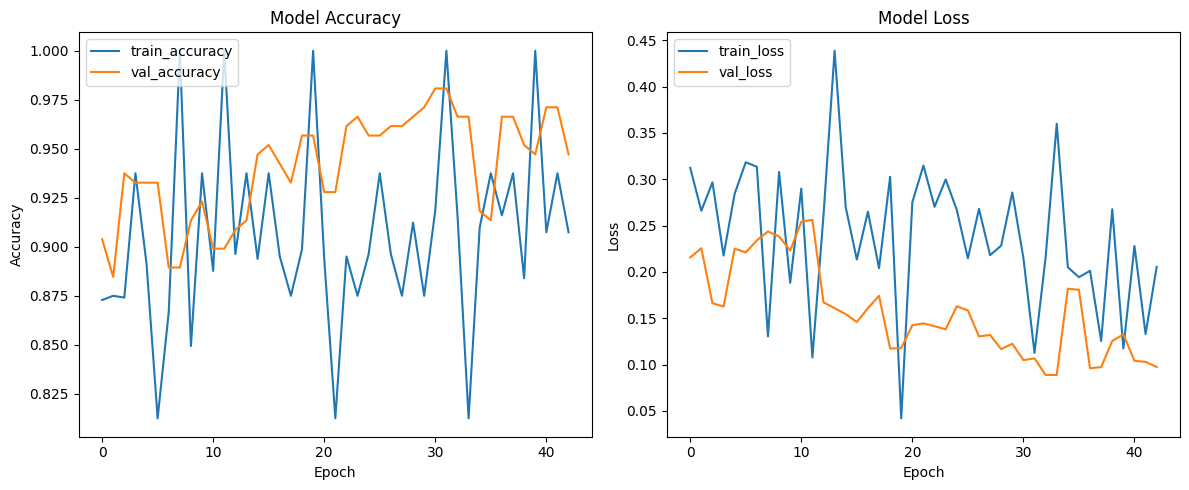

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
model.load_weights('best_model.weights.h5')
print("Loaded best model weights from best_model.weights.h5")

Loaded best model weights from best_model.weights.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Prediction: 1.0000 -> Barcode Detected


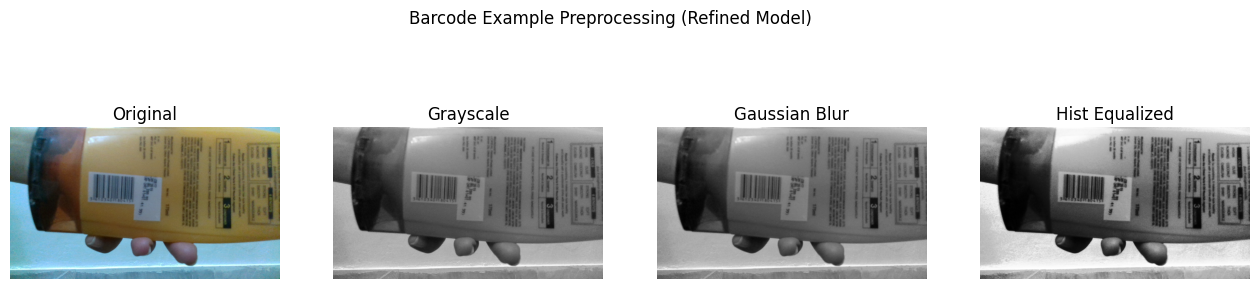

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Test with an image that contains a barcode
img_path_barcode = '/content/drive/MyDrive/Colab Notebooks/DIP project/Barcode Detecttion dataset/1/20201211_1015_rgb.png'
img = image.load_img(img_path_barcode, target_size=(img_size, img_size))
img_arr = image.img_to_array(img)/255.0
img_arr = np.expand_dims(img_arr, axis=0)

pred = model.predict(img_arr)[0][0]
if pred < 0.5:
    print(f'Prediction: {pred:.4f} -> No Barcode Detected')
else:
    print(f'Prediction: {pred:.4f} -> Barcode Detected')
    show_preprocessing(img_path_barcode, "Barcode Example Preprocessing (Refined Model)")

Saving WhatsApp Image 2025-12-30 at 9.36.57 PM (1).jpeg to WhatsApp Image 2025-12-30 at 9.36.57 PM (1).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


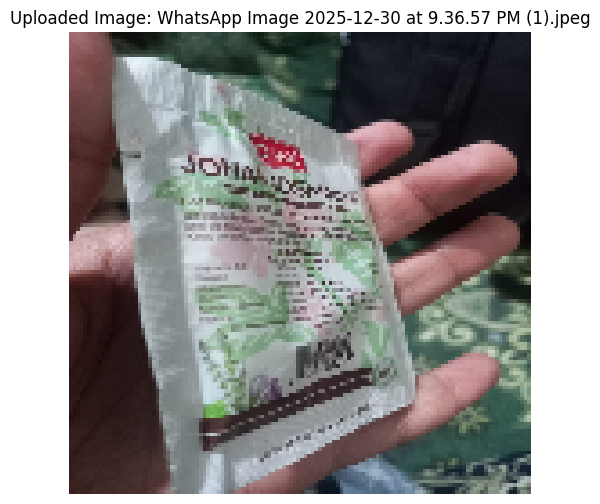

Prediction for WhatsApp Image 2025-12-30 at 9.36.57 PM (1).jpeg: 0.9999 -> Barcode Detected


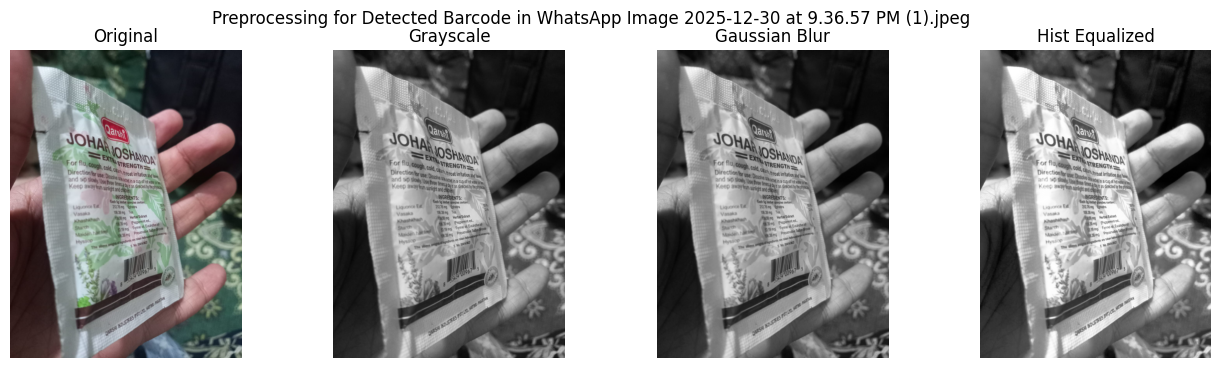

In [ ]:
from google.colab import files
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

uploaded = files.upload()

for fn in uploaded.keys():
    img_path_uploaded = fn

    # Load and preprocess the image for the model
    img = image.load_img(img_path_uploaded, target_size=(img_size, img_size))
    img_arr = image.img_to_array(img)/255.0
    img_arr = np.expand_dims(img_arr, axis=0)

    # Make prediction
    pred = model.predict(img_arr)[0][0]

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Uploaded Image: {fn}")
    plt.axis('off')
    plt.show()

    if pred < 0.5:
        print(f'Prediction for {fn}: {pred:.4f} -> No Barcode Detected')
    else:
        print(f'Prediction for {fn}: {pred:.4f} -> Barcode Detected')
        # Display preprocessing steps if a barcode is detected
        show_preprocessing(img_path_uploaded, f"Preprocessing for Detected Barcode in {fn}")


Saving WhatsApp Image 2025-12-30 at 9.36.56 PM (1).jpeg to WhatsApp Image 2025-12-30 at 9.36.56 PM (1).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


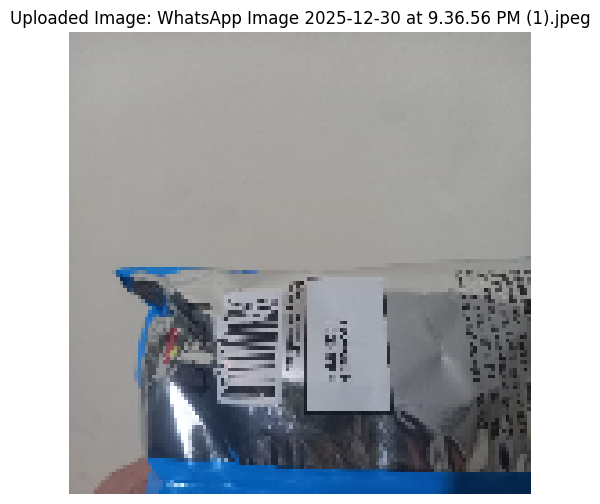

Prediction for WhatsApp Image 2025-12-30 at 9.36.56 PM (1).jpeg: 0.9994 -> Barcode Detected


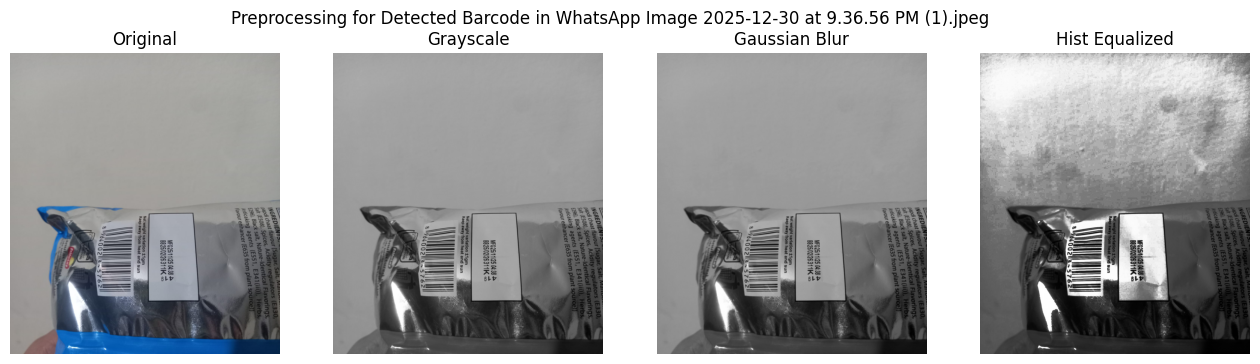

In [ ]:
from google.colab import files
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

uploaded = files.upload()

for fn in uploaded.keys():
    img_path_uploaded = fn

    # Load and preprocess the image for the model
    img = image.load_img(img_path_uploaded, target_size=(img_size, img_size))
    img_arr = image.img_to_array(img)/255.0
    img_arr = np.expand_dims(img_arr, axis=0)

    # Make prediction
    pred = model.predict(img_arr)[0][0]

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Uploaded Image: {fn}")
    plt.axis('off')
    plt.show()

    if pred < 0.5:
        print(f'Prediction for {fn}: {pred:.4f} -> No Barcode Detected')
    else:
        print(f'Prediction for {fn}: {pred:.4f} -> Barcode Detected')
        # Display preprocessing steps if a barcode is detected
        show_preprocessing(img_path_uploaded, f"Preprocessing for Detected Barcode in {fn}")


Saving WhatsApp Image 2025-12-30 at 9.36.56 PM.jpeg to WhatsApp Image 2025-12-30 at 9.36.56 PM (4).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


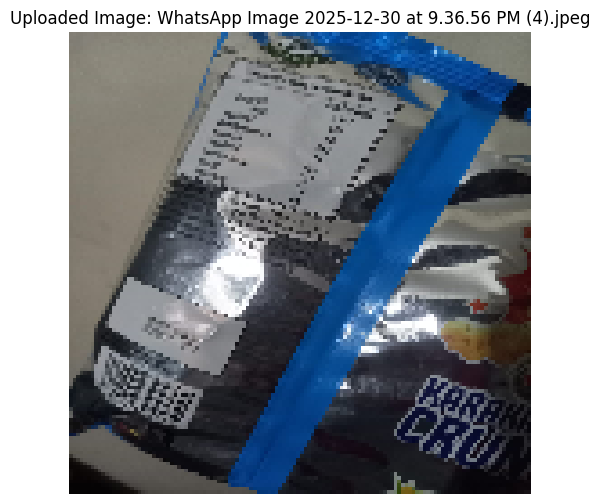

Prediction for WhatsApp Image 2025-12-30 at 9.36.56 PM (4).jpeg: 0.0000 -> No Barcode Detected


In [ ]:
from google.colab import files
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

uploaded = files.upload()

for fn in uploaded.keys():
    img_path_uploaded = fn

    # Load and preprocess the image for the model
    img = image.load_img(img_path_uploaded, target_size=(img_size, img_size))
    img_arr = image.img_to_array(img)/255.0
    img_arr = np.expand_dims(img_arr, axis=0)

    # Make prediction
    pred = model.predict(img_arr)[0][0]

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Uploaded Image: {fn}")
    plt.axis('off')
    plt.show()

    if pred < 0.5:
        print(f'Prediction for {fn}: {pred:.4f} -> No Barcode Detected')
    else:
        print(f'Prediction for {fn}: {pred:.4f} -> Barcode Detected')
        # Display preprocessing steps if a barcode is detected
        show_preprocessing(img_path_uploaded, f"Preprocessing for Detected Barcode in {fn}")


## Prepare ROI Dataset Directories




In [ ]:
import os

roi_base_dir = 'roi_dataset'
roi_train_dir = os.path.join(roi_base_dir, 'train')
roi_val_dir = os.path.join(roi_base_dir, 'validation')

# Create the directory structure for ROI-based dataset
for d in [os.path.join(roi_train_dir, '0'), os.path.join(roi_train_dir, '1'),
          os.path.join(roi_val_dir, '0'), os.path.join(roi_val_dir, '1')]:
    os.makedirs(d, exist_ok=True)

print(f"ROI dataset directories created under '{roi_base_dir}'")

ROI dataset directories created under 'roi_dataset'


In [ ]:
def extract_barcode_roi(img_path, is_barcode, img_size=128):
    img = cv2.imread(img_path)

    if img is None:
        print(f"Warning: Could not load image {img_path}")
        return None

    # Apply preprocessing steps
    _, _, _, eq = preprocess_image(img_path)

    processed_img = None
    if is_barcode:
        # For barcode images, try to extract the barcode ROI
        sobelx, _ = detect_edges(eq)
        morphed = morph_ops(sobelx)

        contours, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        possible_barcodes = []
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            aspect_ratio = w / float(h)
            area = cv2.contourArea(cnt)

            # Relaxed filters for potential barcode regions
            if area > 800 and 1.0 < aspect_ratio < 7.0:
                possible_barcodes.append((x, y, w, h, area))

        if possible_barcodes:
            # Select the largest possible barcode region
            possible_barcodes = sorted(possible_barcodes, key=lambda e: e[4], reverse=True)
            x, y, w, h, _ = possible_barcodes[0]
            processed_img = eq[y:y+h, x:x+w]
        else:
            # Fallback to entire preprocessed image if no suitable ROI found
            processed_img = eq
            # print(f"No barcode ROI found for {img_path}, using full image.")
    else:
        # For non-barcode images, take a central crop of the preprocessed image
        h, w = eq.shape
        start_x = max(0, (w - img_size) // 2)
        start_y = max(0, (h - img_size) // 2)
        end_x = min(w, start_x + img_size)
        end_y = min(h, start_y + img_size)

        # Ensure the crop is exactly img_size x img_size, even if padding is needed
        processed_img = np.zeros((img_size, img_size), dtype=eq.dtype)
        cropped_part = eq[start_y:end_y, start_x:end_x]
        processed_img[0:cropped_part.shape[0], 0:cropped_part.shape[1]] = cropped_part

    # Resize the final processed image to the target size
    if processed_img is not None:
        processed_img = cv2.resize(processed_img, (img_size, img_size))

    return processed_img

print("Defined function 'extract_barcode_roi'.")

Defined function 'extract_barcode_roi'.


In [ ]:
from sklearn.model_selection import train_test_split
import shutil
import uuid

# Split image paths for ROI dataset creation
train_barcode_roi, val_barcode_roi = train_test_split(barcode_imgs, test_size=0.2, random_state=42)
train_nobarcode_roi, val_nobarcode_roi = train_test_split(nobarcode_imgs, test_size=0.2, random_state=42)

def save_roi_images(image_list, destination_folder, is_barcode_flag, img_size=128):
    os.makedirs(destination_folder, exist_ok=True)
    count = 0
    for img_path in image_list:
        processed_img = extract_barcode_roi(img_path, is_barcode_flag, img_size)
        if processed_img is not None:
            # Generate a unique filename
            original_filename = os.path.basename(img_path)
            unique_filename = f"{uuid.uuid4()}_{original_filename}"
            save_path = os.path.join(destination_folder, unique_filename)
            cv2.imwrite(save_path, processed_img)
            count += 1
    print(f"Saved {count} ROI images to {destination_folder}")

print("Populating ROI training and validation datasets...")
save_roi_images(train_barcode_roi, os.path.join(roi_train_dir, '1'), True, img_size)
save_roi_images(train_nobarcode_roi, os.path.join(roi_train_dir, '0'), False, img_size)
save_roi_images(val_barcode_roi, os.path.join(roi_val_dir, '1'), True, img_size)
save_roi_images(val_nobarcode_roi, os.path.join(roi_val_dir, '0'), False, img_size)
print("ROI dataset population complete.")

Populating ROI training and validation datasets...
Saved 566 ROI images to roi_dataset/train/1
Saved 260 ROI images to roi_dataset/train/0
Saved 142 ROI images to roi_dataset/validation/1
Saved 66 ROI images to roi_dataset/validation/0
ROI dataset population complete.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Instantiate ImageDataGenerator for training set with augmentation
train_datagen_roi = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 2. Create training data generator
train_gen_roi = train_datagen_roi.flow_from_directory(
    roi_train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary'
)

# 3. Instantiate ImageDataGenerator for validation set with only rescaling
val_datagen_roi = ImageDataGenerator(rescale=1./255)

# 4. Create validation data generator
val_gen_roi = val_datagen_roi.flow_from_directory(
    roi_val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary'
)

# 5. Print image counts
print(f"Found {train_gen_roi.n} training ROI images belonging to {train_gen_roi.num_classes} classes.")
print(f"Found {val_gen_roi.n} validation ROI images belonging to {val_gen_roi.num_classes} classes.")

Found 826 images belonging to 2 classes.
Found 208 images belonging to 2 classes.
Found 826 training ROI images belonging to 2 classes.
Found 208 validation ROI images belonging to 2 classes.


## Define and Compile Model B (CNN on ROI images)



In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 1. Define Model B with the same architecture as Model A, including dropout layers
model_b = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# 2. Compile Model B
model_b.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 3. Print the summary of model_b
model_b.summary()

# 4. Initialize new EarlyStopping callback for Model B
early_stopping_b = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 5. Initialize new ModelCheckpoint callback for Model B
model_checkpoint_b = ModelCheckpoint(
    'best_model_b.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

print("Model B defined, compiled, and its callbacks initialized.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,699,009 (6.48 MB)

 Trainable params: 1,699,009 (6.48 MB)

 Non-trainable params: 0 (0.00 B)

Model B defined, compiled, and its callbacks initialized.


In [ ]:
history_b = model_b.fit(
    train_gen_roi,
    steps_per_epoch=train_gen_roi.samples // batch_size,
    epochs=50, # Increased epochs as EarlyStopping will handle stopping
    validation_data=val_gen_roi,
    validation_steps=val_gen_roi.samples // batch_size,
    callbacks=[early_stopping_b, model_checkpoint_b]
)
print("Model B training complete.")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.6507 - loss: 0.7525
Epoch 1: val_loss improved from inf to 0.46335, saving model to best_model_b.weights.h5
51/51 ━━━━━━━━━━━━━━━━━━━━ 33s 586ms/step - accuracy: 0.6509 - loss: 0.7502 - val_accuracy: 0.6827 - val_loss: 0.4634
Epoch 2/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 20s 408ms/step - accuracy: 0.6875 - loss: 0.4956

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 0.46335 to 0.44535, saving model to best_model_b.weights.h5
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6875 - loss: 0.4956 - val_accuracy: 0.6827 - val_loss: 0.4453
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.7337 - loss: 0.4449
Epoch 3: val_loss improved from 0.44535 to 0.25463, saving model to best_model_b.weights.h5
51/51 ━━━━━━━━━━━━━━━━━━━━ 30s 587ms/step - accuracy: 0.7345 - loss: 0.4440 - val_accuracy: 0.9279 - val_loss: 0.2546
Epoch 4/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 19s 398ms/step - accuracy: 0.8750 - loss: 0.2836
Epoch 4: val_loss did not improve from 0.25463
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8750 - loss: 0.2836 - val_accuracy: 0.9183 - val_loss: 0.2606
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.9168 - loss: 0.3089
Epoch 5: val_loss improved from 0.25463 to 0.23146, saving model to best_model_b.weights.h5
51/51 ━━━━━━━━━━━━━━━━━━━━ 30s 593ms/step - accuracy: 0.9171 - loss

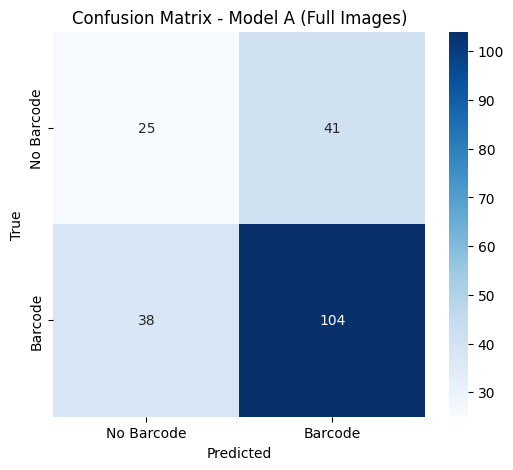

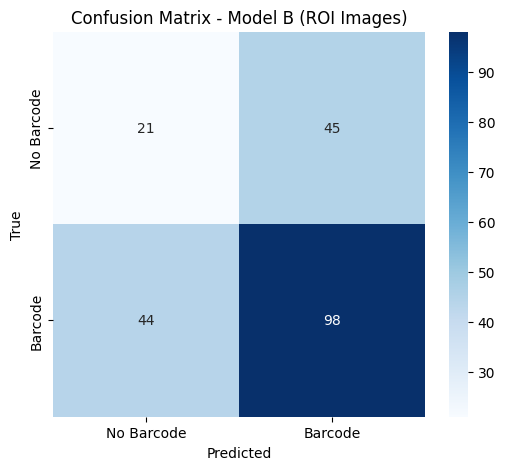

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix for Model A
cm_a = confusion_matrix(y_true_a, y_pred_a)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_a, annot=True, fmt='d', cmap='Blues', xticklabels=['No Barcode', 'Barcode'], yticklabels=['No Barcode', 'Barcode'])
plt.title('Confusion Matrix - Model A (Full Images)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Confusion Matrix for Model B
cm_b = confusion_matrix(y_true_b, y_pred_b)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_b, annot=True, fmt='d', cmap='Blues', xticklabels=['No Barcode', 'Barcode'], yticklabels=['No Barcode', 'Barcode'])
plt.title('Confusion Matrix - Model B (ROI Images)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# 1. Load the best weights for Model A and Model B
model.load_weights('best_model.weights.h5')
print("Loaded best weights for Model A.")

model_b.load_weights('best_model_b.weights.h5')
print("Loaded best weights for Model B.")

# 2. Evaluate Model A on its validation data generator
eval_results_a = model.evaluate(val_gen)
val_loss_a, val_accuracy_a = eval_results_a[0], eval_results_a[1]
print(f"\nModel A - Validation Loss: {val_loss_a:.4f}, Validation Accuracy: {val_accuracy_a:.4f}")

# 3. Evaluate Model B on its ROI validation data generator
eval_results_b = model_b.evaluate(val_gen_roi)
val_loss_b, val_accuracy_b = eval_results_b[0], eval_results_b[1]
print(f"Model B - Validation Loss: {val_loss_b:.4f}, Validation Accuracy: {val_accuracy_b:.4f}")

# Prepare for classification report for Model A
val_gen.reset()
y_pred_a_probs = model.predict(val_gen)
y_pred_a = (y_pred_a_probs > 0.5).astype(int)
y_true_a = val_gen.classes

# Ensure y_true_a and y_pred_a have the same number of samples by slicing y_true_a
# The number of predictions might be slightly off if steps_per_epoch in model.predict was not exactly val_gen.n / batch_size
num_samples_a = len(y_pred_a)
y_true_a = y_true_a[:num_samples_a]

# 5. Calculate and print classification report for Model A
print("\nClassification Report for Model A:")
print(classification_report(y_true_a, y_pred_a))

# Prepare for classification report for Model B
val_gen_roi.reset()
y_pred_b_probs = model_b.predict(val_gen_roi)
y_pred_b = (y_pred_b_probs > 0.5).astype(int)
y_true_b = val_gen_roi.classes

# Ensure y_true_b and y_pred_b have the same number of samples
num_samples_b = len(y_pred_b)
y_true_b = y_true_b[:num_samples_b]

# 7. Calculate and print classification report for Model B
print("\nClassification Report for Model B:")
print(classification_report(y_true_b, y_pred_b))


Loaded best weights for Model A.
Loaded best weights for Model B.
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 572ms/step - accuracy: 0.9800 - loss: 0.0826

Model A - Validation Loss: 0.0888, Validation Accuracy: 0.9663
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.9970 - loss: 0.0029
Model B - Validation Loss: 0.0043, Validation Accuracy: 0.9952
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 752ms/step

Classification Report for Model A:
              precision    recall  f1-score   support

           0       0.40      0.38      0.39        66
           1       0.72      0.73      0.72       142

    accuracy                           0.62       208
   macro avg       0.56      0.56      0.56       208
weighted avg       0.62      0.62      0.62       208

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step

Classification Report for Model B:
              precision    recall  f1-score   support

           0       0.32      0.32      0.32        66
           1       0.69      0.69      0.69       142

    accurac

In [ ]:
import time
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image

# Define sample image paths (using existing ones or picking new random ones)
sample_barcode_img_path = random.choice(val_barcode_roi) # Using a validation barcode image
sample_nobarcode_img_path = random.choice(val_nobarcode_roi) # Using a validation non-barcode image

# Helper function to measure inference time for Model A (full image)
def measure_inference_time_a(model, img_path, img_size):
    start_time = time.time()
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_arr = image.img_to_array(img) / 255.0
    img_arr = np.expand_dims(img_arr, axis=0) # Add batch dimension
    model.predict(img_arr, verbose=0)
    end_time = time.time()
    return end_time - start_time

# Helper function to measure inference time for Model B (ROI image)
def measure_inference_time_b(model_b, img_path, is_barcode_flag, img_size):
    start_time = time.time()

    # Extract ROI using the previously defined function
    processed_roi = extract_barcode_roi(img_path, is_barcode_flag, img_size)

    if processed_roi is None:
        # Handle case where ROI extraction failed or returned None
        print(f"Warning: ROI extraction failed for {img_path}. Returning high inference time.")
        return 999999.0 # Return a very high time to indicate failure

    # Model B expects 3 channels. If processed_roi is grayscale (2D), convert to 3 channels.
    if len(processed_roi.shape) == 2:
        processed_roi_rgb = cv2.cvtColor(processed_roi, cv2.COLOR_GRAY2RGB)
    else:
        processed_roi_rgb = processed_roi

    # Convert to numpy array and rescale
    img_arr_roi = np.array(processed_roi_rgb) / 255.0
    img_arr_roi = np.expand_dims(img_arr_roi, axis=0) # Add batch dimension

    model_b.predict(img_arr_roi, verbose=0)
    end_time = time.time()
    return end_time - start_time

print("Time measurement functions and sample paths defined.")

Time measurement functions and sample paths defined.


In [ ]:
num_runs = 10 # Number of times to run inference for averaging

# Measure inference time for Model A
inference_times_a = []
for _ in range(num_runs):
    inference_times_a.append(measure_inference_time_a(model, sample_barcode_img_path, img_size))
    inference_times_a.append(measure_inference_time_a(model, sample_nobarcode_img_path, img_size))
average_inference_time_a = np.mean(inference_times_a)
print(f"Average Inference Time for Model A: {average_inference_time_a:.4f} seconds")

# Measure inference time for Model B
inference_times_b = []
for _ in range(num_runs):
    inference_times_b.append(measure_inference_time_b(model_b, sample_barcode_img_path, True, img_size))
    inference_times_b.append(measure_inference_time_b(model_b, sample_nobarcode_img_path, False, img_size))
average_inference_time_b = np.mean(inference_times_b)
print(f"Average Inference Time for Model B: {average_inference_time_b:.4f} seconds")

Average Inference Time for Model A: 0.1249 seconds
Average Inference Time for Model B: 0.2313 seconds


Selected sample barcode image for pipeline visualization: /content/drive/MyDrive/Colab Notebooks/DIP project/Barcode Detecttion dataset/1/20201211_3059_rgb.png


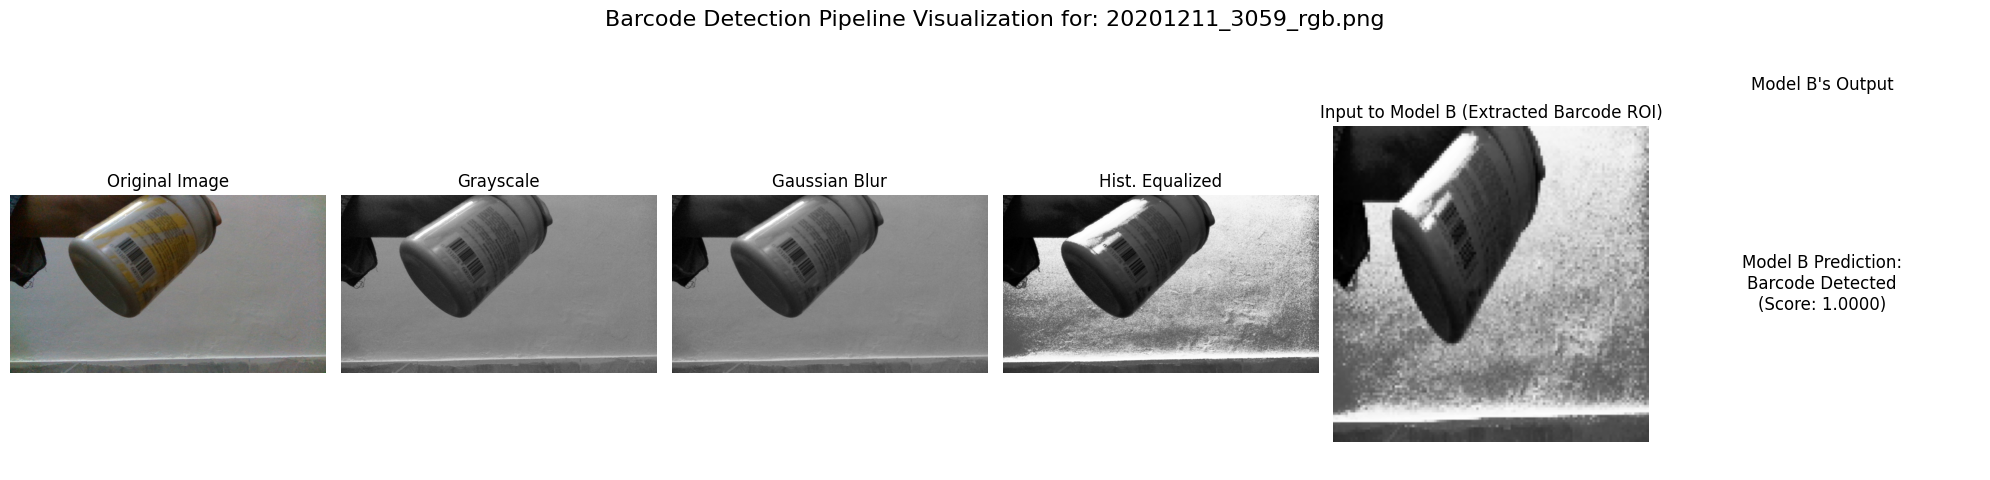

In [ ]:
import matplotlib.pyplot as plt
sample_barcode_img_pipeline = random.choice(barcode_imgs)
print(f"Selected sample barcode image for pipeline visualization: {sample_barcode_img_pipeline}")

# Load the original image and convert to RGB for display
original_img = cv2.imread(sample_barcode_img_pipeline)
original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# 3. Apply the preprocess_image() function
_, gray_img, blur_img, eq_img = preprocess_image(sample_barcode_img_pipeline)
extracted_roi = extract_barcode_roi(sample_barcode_img_pipeline, True, img_size)

if extracted_roi is not None and len(extracted_roi.shape) == 2:
    extracted_roi_rgb = cv2.cvtColor(extracted_roi, cv2.COLOR_GRAY2RGB)
elif extracted_roi is not None:
    extracted_roi_rgb = extracted_roi # Already 3 channels if it came from the original image
else:
    extracted_roi_rgb = np.zeros((img_size, img_size, 3), dtype=np.uint8) # Fallback if ROI extraction fails completely

if len(extracted_roi.shape) == 2:
    roi_for_prediction = cv2.cvtColor(extracted_roi, cv2.COLOR_GRAY2RGB)
else:
    roi_for_prediction = extracted_roi

roi_for_prediction = roi_for_prediction / 255.0 # Rescale
roi_for_prediction = np.expand_dims(roi_for_prediction, axis=0) # Add batch dimension

# 7. Use model_b.predict() on the preprocessed ROI to get the prediction score
prediction_b = model_b.predict(roi_for_prediction, verbose=0)[0][0]
prediction_text_b = "Barcode Detected" if prediction_b > 0.5 else "No Barcode Detected"

# 8. Create a matplotlib figure with multiple subplots
plt.figure(figsize=(20, 5))

images = [
    original_img_rgb,
    gray_img,
    blur_img,
    eq_img,
    extracted_roi_rgb
]
labels = [
    "Original Image",
    "Grayscale",
    "Gaussian Blur",
    "Hist. Equalized",
    "Input to Model B (Extracted Barcode ROI)" # Clarified label
]

for i, (img, label) in enumerate(zip(images, labels)):
    plt.subplot(1, 6, i + 1)
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    plt.title(label)
    plt.axis('off')
plt.subplot(1, 6, 6)
plt.text(0.5, 0.5, f"Model B Prediction:\n{prediction_text_b}\n(Score: {prediction_b:.4f})",
         horizontalalignment='center', verticalalignment='center', fontsize=12)
plt.title("Model B's Output")
plt.axis('off')
plt.suptitle(f"Barcode Detection Pipeline Visualization for: {os.path.basename(sample_barcode_img_pipeline)}", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

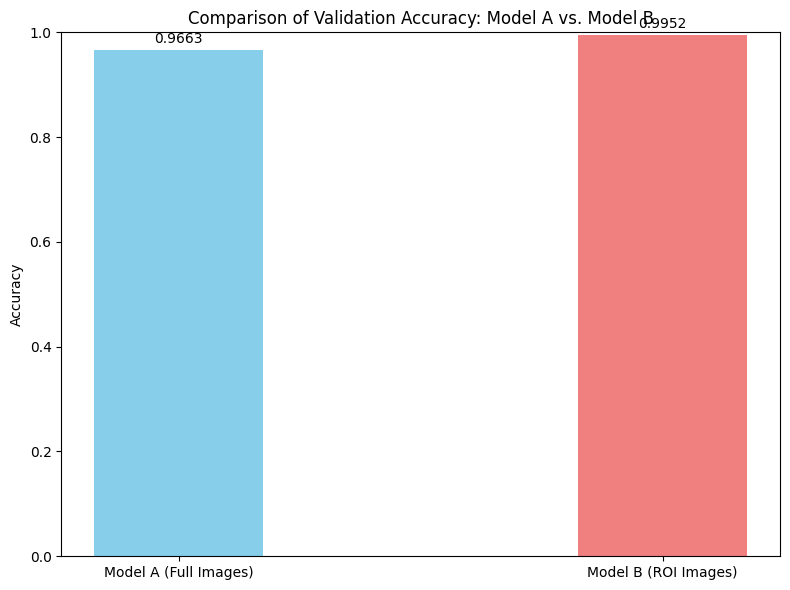

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure accuracy values are available (from previous evaluation step)
# val_accuracy_a = ... # from previous cell
# val_accuracy_b = ... # from previous cell

models = ['Model A (Full Images)', 'Model B (ROI Images)']
accuracies = [val_accuracy_a, val_accuracy_b]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x, accuracies, width, color=['skyblue', 'lightcoral'])

ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Validation Accuracy: Model A vs. Model B')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim([0, 1]) # Accuracy ranges from 0 to 1

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)

plt.tight_layout()
plt.show()

Please upload an image to predict if it contains a barcode.


Saving WhatsApp Image 2025-12-30 at 9.36.56 PM.jpeg to WhatsApp Image 2025-12-30 at 9.36.56 PM (3).jpeg
Prediction for WhatsApp Image 2025-12-30 at 9.36.56 PM (3).jpeg (Model A): 0.0000 -> No Barcode Detected

Model A did not detect a barcode. Trying with Model B (ROI-based)...


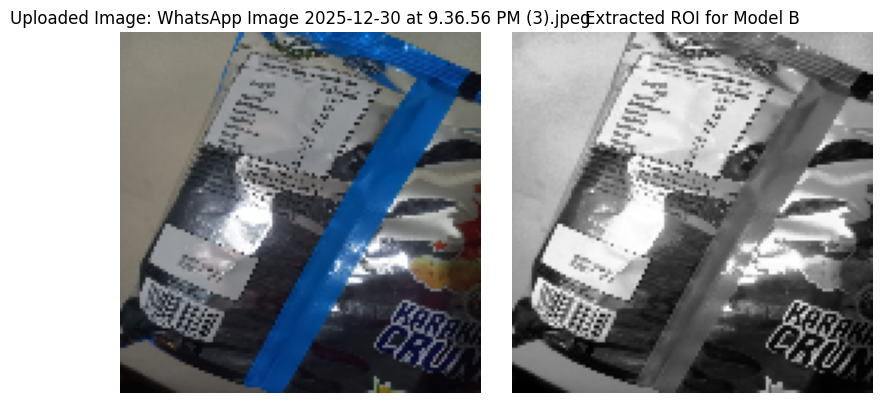

Prediction for WhatsApp Image 2025-12-30 at 9.36.56 PM (3).jpeg (Model B): 1.0000 -> Barcode Detected


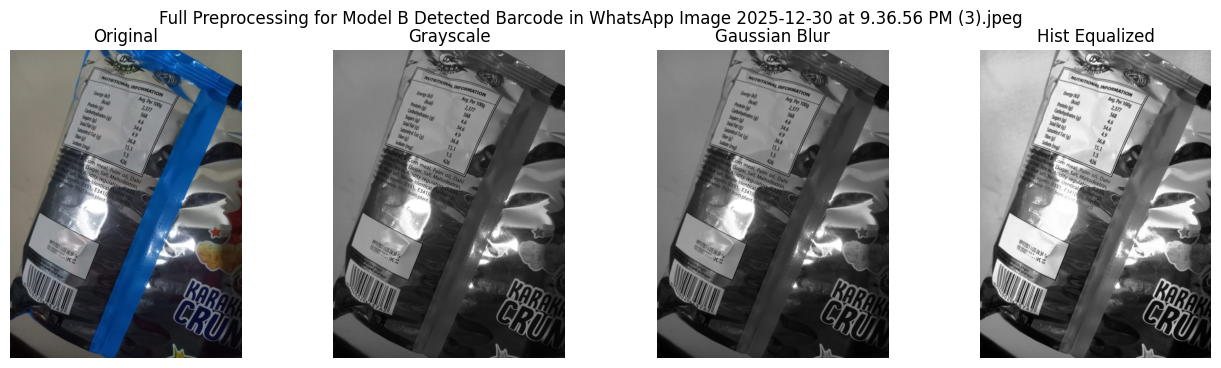

In [ ]:
from google.colab import files
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os
import cv2

print("Please upload an image to predict if it contains a barcode.")
uploaded = files.upload()

for fn in uploaded.keys():
    img_path_uploaded = fn

    # Load and preprocess the image for Model A (full image input)
    img = image.load_img(img_path_uploaded, target_size=(img_size, img_size))
    img_arr_a = image.img_to_array(img)/255.0
    img_arr_a = np.expand_dims(img_arr_a, axis=0) # Add batch dimension

    # Make prediction using Model A
    pred_a = model.predict(img_arr_a, verbose=0)[0][0]

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Uploaded Image: {fn}")
    plt.axis('off')

    if pred_a < 0.5:
        print(f'Prediction for {fn} (Model A): {pred_a:.4f} -> No Barcode Detected')

        # If Model A detects no barcode, try with Model B (ROI-based)
        print(f'\nModel A did not detect a barcode. Trying with Model B (ROI-based)...')

        # Extract ROI using the previously defined function, assuming it contains a barcode for ROI extraction
        processed_roi_b = extract_barcode_roi(img_path_uploaded, is_barcode=True, img_size=img_size)

        if processed_roi_b is None:
            print(f"Could not process the image '{img_path_uploaded}' for Model B.")
        else:
            # Model B expects 3 channels. If processed_roi_b is grayscale (2D), convert to 3 channels.
            if len(processed_roi_b.shape) == 2:
                roi_for_prediction_b = cv2.cvtColor(processed_roi_b, cv2.COLOR_GRAY2RGB)
            else:
                roi_for_prediction_b = processed_roi_b

            roi_for_prediction_b = roi_for_prediction_b / 255.0  # Rescale
            roi_for_prediction_b = np.expand_dims(roi_for_prediction_b, axis=0)  # Add batch dimension

            # Make prediction using Model B
            pred_b = model_b.predict(roi_for_prediction_b, verbose=0)[0][0]

            plt.subplot(1, 2, 2)
            plt.imshow(cv2.cvtColor(processed_roi_b, cv2.COLOR_GRAY2RGB) if len(processed_roi_b.shape) == 2 else processed_roi_b)
            plt.title(f"Extracted ROI for Model B")
            plt.axis('off')
            plt.tight_layout()
            plt.show()

            if pred_b < 0.5:
                print(f'Prediction for {os.path.basename(img_path_uploaded)} (Model B): {pred_b:.4f} -> No Barcode Detected')
            else:
                print(f'Prediction for {os.path.basename(img_path_uploaded)} (Model B): {pred_b:.4f} -> Barcode Detected')
                show_preprocessing(img_path_uploaded, f"Full Preprocessing for Model B Detected Barcode in {os.path.basename(img_path_uploaded)}")

    else:
        # Model A detected a barcode
        plt.tight_layout()
        plt.show()
        print(f'Prediction for {fn} (Model A): {pred_a:.4f} -> Barcode Detected')
        show_preprocessing(img_path_uploaded, f"Preprocessing for Detected Barcode in {fn} (Model A)")


Please upload an image to predict if it contains a barcode.


Saving WhatsApp Image 2025-12-30 at 9.36.57 PM.jpeg to WhatsApp Image 2025-12-30 at 9.36.57 PM (2).jpeg
Prediction for WhatsApp Image 2025-12-30 at 9.36.57 PM (2).jpeg (Model A): 0.2099 -> No Barcode Detected

Model A did not detect a barcode. Trying with Model B (ROI-based)...


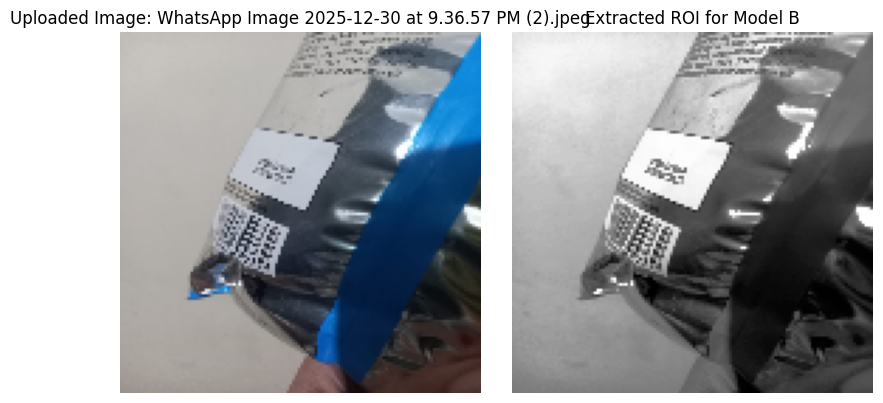

Prediction for WhatsApp Image 2025-12-30 at 9.36.57 PM (2).jpeg (Model B): 1.0000 -> Barcode Detected


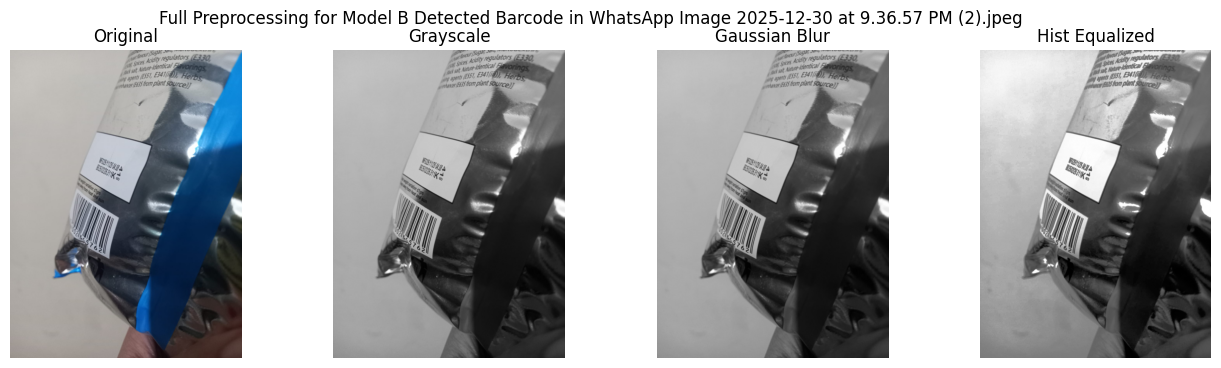

In [ ]:
from google.colab import files
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os
import cv2

print("Please upload an image to predict if it contains a barcode.")
uploaded = files.upload()

for fn in uploaded.keys():
    img_path_uploaded = fn

    # Load and preprocess the image for Model A (full image input)
    img = image.load_img(img_path_uploaded, target_size=(img_size, img_size))
    img_arr_a = image.img_to_array(img)/255.0
    img_arr_a = np.expand_dims(img_arr_a, axis=0) # Add batch dimension

    # Make prediction using Model A
    pred_a = model.predict(img_arr_a, verbose=0)[0][0]

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Uploaded Image: {fn}")
    plt.axis('off')

    if pred_a < 0.5:
        print(f'Prediction for {fn} (Model A): {pred_a:.4f} -> No Barcode Detected')

        # If Model A detects no barcode, try with Model B (ROI-based)
        print(f'\nModel A did not detect a barcode. Trying with Model B (ROI-based)...')

        # Extract ROI using the previously defined function, assuming it contains a barcode for ROI extraction
        processed_roi_b = extract_barcode_roi(img_path_uploaded, is_barcode=True, img_size=img_size)

        if processed_roi_b is None:
            print(f"Could not process the image '{img_path_uploaded}' for Model B.")
        else:
            # Model B expects 3 channels. If processed_roi_b is grayscale (2D), convert to 3 channels.
            if len(processed_roi_b.shape) == 2:
                roi_for_prediction_b = cv2.cvtColor(processed_roi_b, cv2.COLOR_GRAY2RGB)
            else:
                roi_for_prediction_b = processed_roi_b

            roi_for_prediction_b = roi_for_prediction_b / 255.0  # Rescale
            roi_for_prediction_b = np.expand_dims(roi_for_prediction_b, axis=0)  # Add batch dimension

            # Make prediction using Model B
            pred_b = model_b.predict(roi_for_prediction_b, verbose=0)[0][0]

            plt.subplot(1, 2, 2)
            plt.imshow(cv2.cvtColor(processed_roi_b, cv2.COLOR_GRAY2RGB) if len(processed_roi_b.shape) == 2 else processed_roi_b)
            plt.title(f"Extracted ROI for Model B")
            plt.axis('off')
            plt.tight_layout()
            plt.show()

            if pred_b < 0.5:
                print(f'Prediction for {os.path.basename(img_path_uploaded)} (Model B): {pred_b:.4f} -> No Barcode Detected')
            else:
                print(f'Prediction for {os.path.basename(img_path_uploaded)} (Model B): {pred_b:.4f} -> Barcode Detected')
                show_preprocessing(img_path_uploaded, f"Full Preprocessing for Model B Detected Barcode in {os.path.basename(img_path_uploaded)}")

    else:
        # Model A detected a barcode
        plt.tight_layout()
        plt.show()
        print(f'Prediction for {fn} (Model A): {pred_a:.4f} -> Barcode Detected')
        show_preprocessing(img_path_uploaded, f"Preprocessing for Detected Barcode in {fn} (Model A)")
